In [1]:
import wandb
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score
from wandb.lightgbm import wandb_callback, log_summary
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
wandb.login()

wandb: Currently logged in as: d-a-pop (midigpt). Use `wandb login --relogin` to force relogin


True

## Final

In [55]:
def parse_data():
    # read and prepare data for training
    train = pd.read_csv("train.csv")
    val = pd.read_csv("val.csv")

    train['user_id'] = train['user_id'].astype("category")
    train['review_id'] = train['review_id'].astype("category")
    train['book_id'] = train['book_id'].astype("category")
    train = train.drop("review_text", axis=1)

    val['user_id'] = val['user_id'].astype("category")
    val['review_id'] = val['review_id'].astype("category")
    val['book_id'] = val['book_id'].astype("category")
    val = val.drop("review_text", axis=1)
    
    return train, val

In [4]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

In [5]:
def train(config):
    # perform one training iteration
    train, val = parse_data()
    
    model = lgb.LGBMClassifier(boosting_type=config["boosting_type"], num_leaves=config["num_leaves"], 
                               max_depth=config["max_depth"], learning_rate=config["learning_rate"], 
                               n_estimators=config["n_estimators"], min_child_samples=config["min_child_samples"], 
                               subsample=config["subsample"], colsample_bytree=config["colsample_bytree"], 
                               random_state=config["random_state"], reg_alpha=config["reg_alpha"], 
                               reg_lambda=config["reg_lambda"])
    
    train_config = model.get_params()
    print("TRAIN CONFIG")
    print(train_config)
    
    run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    
    
    gbm = model.fit(train.drop("rating", axis=1), train["rating"], callbacks=[wandb_callback()], \
                     categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb, \
                     eval_set=[(train.drop("rating", axis=1), train["rating"]), (val.drop("rating", axis=1), val["rating"])], \
                     eval_names=["training", "validation"]);

    log_summary(gbm.booster_)
    
    if config["log_preds"]:
        ypred_ = model.predict_proba(val.drop("rating", axis=1))
        predictions = val[["review_id", "rating"]]
        predictions["pred"] = np.argmax(ypred_, axis=1)
        table = wandb.Table(dataframe=predictions)
        wandb.log({"pred_table":table})
    
    run.finish()
    


In [56]:
train, val = parse_data()

In [57]:
train.columns

Index(['user_id', 'book_id', 'review_id', 'n_votes', 'n_comments', 'rating',
       'missing_started_at', 'review_length', 'hour_read_at', 'hour_added',
       'hour_updated', 'month_read_at', 'month_added', 'month_updated',
       'dayofweek_read_at', 'dayofweek_added', 'dayofweek_updated',
       'year_read_at', 'year_added', 'year_updated', 'spoiler', 'updated',
       'update_duration', 'read_duration', 'added_at_read', 'added_at_start',
       'updated_at_read', 'duration_added_at_read', 'duration_added_at_start',
       'duration_updated_at_read'],
      dtype='object')

In [58]:
val.columns

Index(['user_id', 'book_id', 'review_id', 'n_votes', 'n_comments', 'rating',
       'missing_started_at', 'review_length', 'hour_read_at', 'hour_added',
       'hour_updated', 'month_read_at', 'month_added', 'month_updated',
       'dayofweek_read_at', 'dayofweek_added', 'dayofweek_updated',
       'year_read_at', 'year_added', 'year_updated', 'spoiler', 'updated',
       'update_duration', 'read_duration', 'added_at_read',
       'duration_added_at_read', 'added_at_start', 'duration_added_at_start',
       'updated_at_read', 'duration_updated_at_read'],
      dtype='object')

In [8]:
config = {"log_preds":True, "boosting_type":"gbdt", "num_leaves":48, "max_depth":-1, "learning_rate":0.1, 
     "n_estimators":300, "min_child_samples":20, "subsample":0.95, "colsample_bytree":0.95, "random_state":42, 
     "reg_alpha":0.01, "reg_lambda":0.04}

In [9]:
model = lgb.LGBMClassifier(boosting_type=config["boosting_type"], num_leaves=config["num_leaves"], 
                               max_depth=config["max_depth"], learning_rate=config["learning_rate"], 
                               n_estimators=config["n_estimators"], min_child_samples=config["min_child_samples"], 
                               subsample=config["subsample"], colsample_bytree=config["colsample_bytree"], 
#                                random_state=config["random_state"],
                               reg_alpha=config["reg_alpha"], 
                               reg_lambda=config["reg_lambda"])

In [10]:
train_config = model.get_params()
print("CONFIG")
print(train_config)

CONFIG
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.95, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 48, 'objective': None, 'random_state': None, 'reg_alpha': 0.01, 'reg_lambda': 0.04, 'silent': True, 'subsample': 0.95, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [11]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    

wandb: Currently logged in as: d-a-pop. Use `wandb login --relogin` to force relogin


In [12]:
gbm = model.fit(train.drop("rating", axis=1), train["rating"], callbacks=[wandb_callback()], \
                 categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb, \
                 eval_set=[(train.drop("rating", axis=1), train["rating"]), (val.drop("rating", axis=1), val["rating"])], \
                 eval_names=["training", "validation"]);


/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['book_id', 'review_id', 'user_id']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's multi_logloss: 1.43628	training's macroF1: 0.131939	validation's multi_logloss: 1.43761	validation's macroF1: 0.128939
[2]	training's multi_logloss: 1.41059	training's macroF1: 0.184909	validation's multi_logloss: 1.41567	validation's macroF1: 0.177272
[3]	training's multi_logloss: 1.39083	training's macroF1: 0.210006	validation's multi_logloss: 1.39868	validation's macroF1: 0.203794
[4]	training's multi_logloss: 1.37419	training's macroF1: 0.22695	validation's multi_logloss: 1.3852	validation's macroF1: 0.218658
[5]	training's multi_logloss: 1.35983	training's macroF1: 0.24885	validation's multi_logloss: 1.37354	validation's macroF1: 0.240693
[6]	training's multi_logloss: 1.34805	training's macroF1: 0.262434	validation's multi_logloss: 1.36505	validation's macroF1: 0.249616
[7]	training's multi_logloss: 1.33687	training's macroF1: 0.275467	validation's multi_logloss: 1.3574	validation's macroF1: 0.25945
[8]	training's multi_logloss: 1.32706	training's macroF1: 0.285564	

[62]	training's multi_logloss: 1.12326	training's macroF1: 0.476466	validation's multi_logloss: 1.24668	validation's macroF1: 0.37646
[63]	training's multi_logloss: 1.12138	training's macroF1: 0.478072	validation's multi_logloss: 1.24605	validation's macroF1: 0.376983
[64]	training's multi_logloss: 1.11965	training's macroF1: 0.47973	validation's multi_logloss: 1.2455	validation's macroF1: 0.37755
[65]	training's multi_logloss: 1.1178	training's macroF1: 0.481159	validation's multi_logloss: 1.24502	validation's macroF1: 0.377886
[66]	training's multi_logloss: 1.11598	training's macroF1: 0.482793	validation's multi_logloss: 1.24442	validation's macroF1: 0.378949
[67]	training's multi_logloss: 1.11428	training's macroF1: 0.484065	validation's multi_logloss: 1.2438	validation's macroF1: 0.379285
[68]	training's multi_logloss: 1.11253	training's macroF1: 0.485724	validation's multi_logloss: 1.24336	validation's macroF1: 0.37936
[69]	training's multi_logloss: 1.11085	training's macroF1: 0.4

[123]	training's multi_logloss: 1.03957	training's macroF1: 0.549402	validation's multi_logloss: 1.23034	validation's macroF1: 0.396649
[124]	training's multi_logloss: 1.0385	training's macroF1: 0.550313	validation's multi_logloss: 1.23022	validation's macroF1: 0.39718
[125]	training's multi_logloss: 1.0374	training's macroF1: 0.551405	validation's multi_logloss: 1.23007	validation's macroF1: 0.397436
[126]	training's multi_logloss: 1.03612	training's macroF1: 0.552527	validation's multi_logloss: 1.22994	validation's macroF1: 0.397596
[127]	training's multi_logloss: 1.03517	training's macroF1: 0.553178	validation's multi_logloss: 1.22991	validation's macroF1: 0.397761
[128]	training's multi_logloss: 1.03414	training's macroF1: 0.554029	validation's multi_logloss: 1.22994	validation's macroF1: 0.397905
[129]	training's multi_logloss: 1.0329	training's macroF1: 0.555086	validation's multi_logloss: 1.22988	validation's macroF1: 0.397702
[130]	training's multi_logloss: 1.03202	training's m

[184]	training's multi_logloss: 0.983642	training's macroF1: 0.594459	validation's multi_logloss: 1.22932	validation's macroF1: 0.403424
[185]	training's multi_logloss: 0.982834	training's macroF1: 0.595067	validation's multi_logloss: 1.22945	validation's macroF1: 0.403785
[186]	training's multi_logloss: 0.982238	training's macroF1: 0.59546	validation's multi_logloss: 1.22942	validation's macroF1: 0.403425
[187]	training's multi_logloss: 0.981206	training's macroF1: 0.596151	validation's multi_logloss: 1.22943	validation's macroF1: 0.403395
[188]	training's multi_logloss: 0.980522	training's macroF1: 0.596753	validation's multi_logloss: 1.2294	validation's macroF1: 0.4036
[189]	training's multi_logloss: 0.979835	training's macroF1: 0.597334	validation's multi_logloss: 1.2294	validation's macroF1: 0.403745
[190]	training's multi_logloss: 0.978776	training's macroF1: 0.598381	validation's multi_logloss: 1.22945	validation's macroF1: 0.403917
[191]	training's multi_logloss: 0.977848	train

[245]	training's multi_logloss: 0.94028	training's macroF1: 0.628653	validation's multi_logloss: 1.23223	validation's macroF1: 0.405864
[246]	training's multi_logloss: 0.939661	training's macroF1: 0.629046	validation's multi_logloss: 1.23228	validation's macroF1: 0.40589
[247]	training's multi_logloss: 0.939137	training's macroF1: 0.629448	validation's multi_logloss: 1.23234	validation's macroF1: 0.405966
[248]	training's multi_logloss: 0.938522	training's macroF1: 0.629963	validation's multi_logloss: 1.23237	validation's macroF1: 0.406161
[249]	training's multi_logloss: 0.937911	training's macroF1: 0.630436	validation's multi_logloss: 1.23241	validation's macroF1: 0.406057
[250]	training's multi_logloss: 0.937305	training's macroF1: 0.631115	validation's multi_logloss: 1.23248	validation's macroF1: 0.406061
[251]	training's multi_logloss: 0.936749	training's macroF1: 0.631625	validation's multi_logloss: 1.23261	validation's macroF1: 0.406101
[252]	training's multi_logloss: 0.936027	tr

In [13]:
log_summary(gbm.booster_)

In [14]:
ypred_ = model.predict_proba(val.drop("rating", axis=1))
predictions = val[["review_id", "rating"]]
predictions["pred"] = np.argmax(ypred_, axis=1)

<ipython-input-14-a254c2dc5562>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["pred"] = np.argmax(ypred_, axis=1)


In [15]:
f1_score(val["rating"],predictions["pred"],average="macro")

0.4076348069457896

In [16]:
# table = wandb.Table(dataframe=predictions)
# wandb.log({"pred_table":table})

In [17]:
run.finish()

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
training_macroF1,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
training_multi_logloss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_macroF1,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████████████████████████
validation_multi_logloss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,0
iteration,299
training_macroF1,0.65381
validation_macroF1,0.40763


## Submission

In [18]:
test = pd.read_csv("test.csv")
r = test["review_id"]
test['user_id'] = test['user_id'].astype("category")
test['review_id'] = test['review_id'].astype("category")
test['book_id'] = test['book_id'].astype("category")
test = test.drop("review_text", axis=1)

In [19]:
p = model.predict_proba(test)
s = pd.Series(np.argmax(p, axis=1))
len(s)

478033

In [20]:
len(test)

478033

In [21]:
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [22]:
submission.to_csv("sub9.csv", index=False)

## Train on train and val sets

In [24]:
# train, val = parse_data()

In [26]:
# len(val)

90000

In [23]:
df = pd.concat([train, val])

In [24]:
len(df)

900000

In [25]:
df['user_id'] = df['user_id'].astype("category")
df['review_id'] = df['review_id'].astype("category")
df['book_id'] = df['book_id'].astype("category")

In [38]:
# config = {"log_preds":True, "boosting_type":"gbdt", "num_leaves":41, "max_depth":-1, "learning_rate":0.1, 
#      "n_estimators":300, "min_child_samples":20, "subsample":1.0, "colsample_bytree":1.0, "random_state":42, 
#      "reg_alpha":0, "reg_lambda":0.01}

In [26]:
model1 = lgb.LGBMClassifier(boosting_type=config["boosting_type"], num_leaves=config["num_leaves"], 
                               max_depth=config["max_depth"], learning_rate=config["learning_rate"], 
                               n_estimators=config["n_estimators"], min_child_samples=config["min_child_samples"], 
                               subsample=config["subsample"], colsample_bytree=config["colsample_bytree"], 
                               random_state=config["random_state"], reg_alpha=config["reg_alpha"], 
                               reg_lambda=config["reg_lambda"])

In [27]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    

In [28]:
train_config = model1.get_params()
print("TRAIN CONFIG")
print(train_config)

TRAIN CONFIG
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.95, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 48, 'objective': None, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.04, 'silent': True, 'subsample': 0.95, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [29]:
gbm = model1.fit(df.drop("rating", axis=1), df["rating"], callbacks=[wandb_callback()], \
                 categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb)

/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [30]:
log_summary(gbm.booster_)

In [31]:
run.finish()

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
best_iteration,0
iteration,299


In [112]:
test = pd.read_csv("test.csv")
r = test["review_id"]
test['user_id'] = test['user_id'].astype("category")
test['review_id'] = test['review_id'].astype("category")
test['book_id'] = test['book_id'].astype("category")
test = test.drop("review_text", axis=1)

In [33]:
p = model1.predict_proba(test)
s = pd.Series(np.argmax(p, axis=1))
len(s)

478033

In [34]:
len(test)

478033

In [35]:
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [36]:
submission.to_csv("sub10.csv", index=False)

## CatBoost

In [94]:
import catboost as cb
from catboost import CatBoostRegressor, CatBoostClassifier
from wandb.catboost import log_summary, WandbCallback

In [95]:
val = val.reindex(sorted(train.columns), axis=1)
train = train.reindex(sorted(train.columns), axis=1)

In [104]:
model12 = CatBoostClassifier(verbose=1, eval_metric="TotalF1")

In [105]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    

In [106]:
model12.fit(train.drop("rating", axis=1), train["rating"], \
            cat_features=["user_id", "book_id", "review_id"], \
            eval_set=[(train.drop("rating", axis=1), train["rating"]), (val.drop("rating", axis=1), val["rating"])], \
            callbacks=[WandbCallback()])
            

Learning rate set to 0.123452
0:	learn: 0.3801207	test: 0.4072053	test1: 0.3897760	best: 0.3897760 (0)	total: 1.2s	remaining: 19m 54s
1:	learn: 0.3765812	test: 0.4051092	test1: 0.3883302	best: 0.3897760 (0)	total: 2.28s	remaining: 18m 59s
2:	learn: 0.3810168	test: 0.4064872	test1: 0.3919779	best: 0.3919779 (2)	total: 2.89s	remaining: 16m 1s
3:	learn: 0.3812117	test: 0.4070877	test1: 0.3925754	best: 0.3925754 (3)	total: 3.52s	remaining: 14m 36s
4:	learn: 0.3826734	test: 0.4094001	test1: 0.3941951	best: 0.3941951 (4)	total: 4.16s	remaining: 13m 47s
5:	learn: 0.3880020	test: 0.4178652	test1: 0.4011158	best: 0.4011158 (5)	total: 4.93s	remaining: 13m 37s
6:	learn: 0.3898328	test: 0.4209548	test1: 0.4038223	best: 0.4038223 (6)	total: 5.53s	remaining: 13m 3s
7:	learn: 0.3922148	test: 0.4241951	test1: 0.4061360	best: 0.4061360 (7)	total: 6.11s	remaining: 12m 38s
8:	learn: 0.3929259	test: 0.4251060	test1: 0.4067469	best: 0.4067469 (8)	total: 6.76s	remaining: 12m 24s
9:	learn: 0.3938469	test: 0.

77:	learn: 0.4260781	test: 0.4672631	test1: 0.4401588	best: 0.4401588 (77)	total: 1m 19s	remaining: 15m 39s
78:	learn: 0.4262286	test: 0.4676358	test1: 0.4404905	best: 0.4404905 (78)	total: 1m 20s	remaining: 15m 38s
79:	learn: 0.4263276	test: 0.4677918	test1: 0.4405356	best: 0.4405356 (79)	total: 1m 21s	remaining: 15m 34s
80:	learn: 0.4264138	test: 0.4680481	test1: 0.4402618	best: 0.4405356 (79)	total: 1m 22s	remaining: 15m 32s
81:	learn: 0.4266452	test: 0.4683962	test1: 0.4403411	best: 0.4405356 (79)	total: 1m 23s	remaining: 15m 34s
82:	learn: 0.4267798	test: 0.4686046	test1: 0.4408081	best: 0.4408081 (82)	total: 1m 24s	remaining: 15m 33s
83:	learn: 0.4269783	test: 0.4688701	test1: 0.4408694	best: 0.4408694 (83)	total: 1m 25s	remaining: 15m 34s
84:	learn: 0.4270865	test: 0.4689788	test1: 0.4409172	best: 0.4409172 (84)	total: 1m 26s	remaining: 15m 33s
85:	learn: 0.4271222	test: 0.4690630	test1: 0.4409061	best: 0.4409172 (84)	total: 1m 27s	remaining: 15m 32s
86:	learn: 0.4272304	test: 0

152:	learn: 0.4341598	test: 0.4799781	test1: 0.4469971	best: 0.4470912 (151)	total: 2m 46s	remaining: 15m 23s
153:	learn: 0.4343303	test: 0.4801517	test1: 0.4472709	best: 0.4472709 (153)	total: 2m 48s	remaining: 15m 23s
154:	learn: 0.4344476	test: 0.4803865	test1: 0.4475067	best: 0.4475067 (154)	total: 2m 49s	remaining: 15m 22s
155:	learn: 0.4344596	test: 0.4804412	test1: 0.4475719	best: 0.4475719 (155)	total: 2m 50s	remaining: 15m 21s
156:	learn: 0.4345169	test: 0.4805226	test1: 0.4475003	best: 0.4475719 (155)	total: 2m 51s	remaining: 15m 18s
157:	learn: 0.4345341	test: 0.4806193	test1: 0.4474943	best: 0.4475719 (155)	total: 2m 52s	remaining: 15m 18s
158:	learn: 0.4345925	test: 0.4807138	test1: 0.4476922	best: 0.4476922 (158)	total: 2m 53s	remaining: 15m 17s
159:	learn: 0.4347033	test: 0.4807556	test1: 0.4476474	best: 0.4476922 (158)	total: 2m 54s	remaining: 15m 16s
160:	learn: 0.4347390	test: 0.4810081	test1: 0.4479714	best: 0.4479714 (160)	total: 2m 55s	remaining: 15m 15s
161:	learn

227:	learn: 0.4382658	test: 0.4872962	test1: 0.4504778	best: 0.4504778 (227)	total: 4m 13s	remaining: 14m 18s
228:	learn: 0.4382939	test: 0.4874290	test1: 0.4505041	best: 0.4505041 (228)	total: 4m 14s	remaining: 14m 17s
229:	learn: 0.4383632	test: 0.4875324	test1: 0.4506650	best: 0.4506650 (229)	total: 4m 16s	remaining: 14m 17s
230:	learn: 0.4383895	test: 0.4875640	test1: 0.4506363	best: 0.4506650 (229)	total: 4m 17s	remaining: 14m 16s
231:	learn: 0.4383734	test: 0.4875883	test1: 0.4506286	best: 0.4506650 (229)	total: 4m 18s	remaining: 14m 15s
232:	learn: 0.4383785	test: 0.4876283	test1: 0.4505426	best: 0.4506650 (229)	total: 4m 19s	remaining: 14m 15s
233:	learn: 0.4384110	test: 0.4877627	test1: 0.4506279	best: 0.4506650 (229)	total: 4m 20s	remaining: 14m 14s
234:	learn: 0.4384825	test: 0.4878223	test1: 0.4506538	best: 0.4506650 (229)	total: 4m 22s	remaining: 14m 13s
235:	learn: 0.4385659	test: 0.4878832	test1: 0.4507067	best: 0.4507067 (235)	total: 4m 23s	remaining: 14m 12s
236:	learn

302:	learn: 0.4419947	test: 0.4941924	test1: 0.4540546	best: 0.4540727 (301)	total: 5m 40s	remaining: 13m 4s
303:	learn: 0.4420498	test: 0.4942209	test1: 0.4541300	best: 0.4541300 (303)	total: 5m 42s	remaining: 13m 3s
304:	learn: 0.4420619	test: 0.4942990	test1: 0.4541717	best: 0.4541717 (304)	total: 5m 43s	remaining: 13m 2s
305:	learn: 0.4421641	test: 0.4944195	test1: 0.4543518	best: 0.4543518 (305)	total: 5m 44s	remaining: 13m 1s
306:	learn: 0.4422343	test: 0.4944688	test1: 0.4543502	best: 0.4543518 (305)	total: 5m 45s	remaining: 12m 59s
307:	learn: 0.4422401	test: 0.4944520	test1: 0.4542143	best: 0.4543518 (305)	total: 5m 46s	remaining: 12m 58s
308:	learn: 0.4422975	test: 0.4945321	test1: 0.4542576	best: 0.4543518 (305)	total: 5m 47s	remaining: 12m 57s
309:	learn: 0.4423085	test: 0.4945919	test1: 0.4541660	best: 0.4543518 (305)	total: 5m 48s	remaining: 12m 56s
310:	learn: 0.4423227	test: 0.4945356	test1: 0.4541502	best: 0.4543518 (305)	total: 5m 49s	remaining: 12m 54s
311:	learn: 0.

377:	learn: 0.4446458	test: 0.4985875	test1: 0.4556410	best: 0.4559656 (374)	total: 7m 4s	remaining: 11m 38s
378:	learn: 0.4446914	test: 0.4987581	test1: 0.4557875	best: 0.4559656 (374)	total: 7m 5s	remaining: 11m 37s
379:	learn: 0.4447421	test: 0.4988714	test1: 0.4559346	best: 0.4559656 (374)	total: 7m 6s	remaining: 11m 36s
380:	learn: 0.4447329	test: 0.4988983	test1: 0.4558282	best: 0.4559656 (374)	total: 7m 7s	remaining: 11m 35s
381:	learn: 0.4447817	test: 0.4989223	test1: 0.4559821	best: 0.4559821 (381)	total: 7m 9s	remaining: 11m 34s
382:	learn: 0.4448054	test: 0.4990413	test1: 0.4561457	best: 0.4561457 (382)	total: 7m 10s	remaining: 11m 33s
383:	learn: 0.4447952	test: 0.4991469	test1: 0.4560497	best: 0.4561457 (382)	total: 7m 11s	remaining: 11m 32s
384:	learn: 0.4447787	test: 0.4992449	test1: 0.4560935	best: 0.4561457 (382)	total: 7m 12s	remaining: 11m 30s
385:	learn: 0.4448195	test: 0.4992894	test1: 0.4561548	best: 0.4561548 (385)	total: 7m 13s	remaining: 11m 29s
386:	learn: 0.4

452:	learn: 0.4471162	test: 0.5026965	test1: 0.4574696	best: 0.4575398 (451)	total: 8m 30s	remaining: 10m 16s
453:	learn: 0.4471718	test: 0.5028839	test1: 0.4573682	best: 0.4575398 (451)	total: 8m 31s	remaining: 10m 14s
454:	learn: 0.4472216	test: 0.5029223	test1: 0.4573300	best: 0.4575398 (451)	total: 8m 32s	remaining: 10m 13s
455:	learn: 0.4472843	test: 0.5029333	test1: 0.4575238	best: 0.4575398 (451)	total: 8m 33s	remaining: 10m 13s
456:	learn: 0.4473063	test: 0.5029366	test1: 0.4574776	best: 0.4575398 (451)	total: 8m 34s	remaining: 10m 11s
457:	learn: 0.4473015	test: 0.5029741	test1: 0.4573653	best: 0.4575398 (451)	total: 8m 35s	remaining: 10m 10s
458:	learn: 0.4472780	test: 0.5030047	test1: 0.4573385	best: 0.4575398 (451)	total: 8m 37s	remaining: 10m 9s
459:	learn: 0.4472974	test: 0.5030808	test1: 0.4572657	best: 0.4575398 (451)	total: 8m 38s	remaining: 10m 8s
460:	learn: 0.4473134	test: 0.5030448	test1: 0.4572656	best: 0.4575398 (451)	total: 8m 39s	remaining: 10m 7s
461:	learn: 0

528:	learn: 0.4491252	test: 0.5063502	test1: 0.4583291	best: 0.4583291 (528)	total: 9m 59s	remaining: 8m 54s
529:	learn: 0.4492429	test: 0.5064242	test1: 0.4583970	best: 0.4583970 (529)	total: 10m	remaining: 8m 52s
530:	learn: 0.4492726	test: 0.5064729	test1: 0.4584556	best: 0.4584556 (530)	total: 10m 1s	remaining: 8m 51s
531:	learn: 0.4493057	test: 0.5064965	test1: 0.4585826	best: 0.4585826 (531)	total: 10m 2s	remaining: 8m 50s
532:	learn: 0.4493095	test: 0.5064828	test1: 0.4585384	best: 0.4585826 (531)	total: 10m 4s	remaining: 8m 49s
533:	learn: 0.4494069	test: 0.5066297	test1: 0.4585735	best: 0.4585826 (531)	total: 10m 5s	remaining: 8m 48s
534:	learn: 0.4494193	test: 0.5067740	test1: 0.4587652	best: 0.4587652 (534)	total: 10m 6s	remaining: 8m 46s
535:	learn: 0.4494982	test: 0.5069104	test1: 0.4587392	best: 0.4587652 (534)	total: 10m 7s	remaining: 8m 45s
536:	learn: 0.4494964	test: 0.5069892	test1: 0.4587442	best: 0.4587652 (534)	total: 10m 8s	remaining: 8m 44s
537:	learn: 0.4494296	

603:	learn: 0.4512142	test: 0.5095128	test1: 0.4595906	best: 0.4597209 (590)	total: 11m 21s	remaining: 7m 26s
604:	learn: 0.4512249	test: 0.5094544	test1: 0.4595257	best: 0.4597209 (590)	total: 11m 22s	remaining: 7m 25s
605:	learn: 0.4513020	test: 0.5094748	test1: 0.4594376	best: 0.4597209 (590)	total: 11m 23s	remaining: 7m 24s
606:	learn: 0.4512555	test: 0.5095225	test1: 0.4594706	best: 0.4597209 (590)	total: 11m 25s	remaining: 7m 23s
607:	learn: 0.4513283	test: 0.5095493	test1: 0.4594431	best: 0.4597209 (590)	total: 11m 26s	remaining: 7m 22s
608:	learn: 0.4513824	test: 0.5095680	test1: 0.4594369	best: 0.4597209 (590)	total: 11m 27s	remaining: 7m 21s
609:	learn: 0.4513855	test: 0.5095808	test1: 0.4594462	best: 0.4597209 (590)	total: 11m 29s	remaining: 7m 20s
610:	learn: 0.4514313	test: 0.5096304	test1: 0.4595339	best: 0.4597209 (590)	total: 11m 30s	remaining: 7m 19s
611:	learn: 0.4514060	test: 0.5096553	test1: 0.4595222	best: 0.4597209 (590)	total: 11m 31s	remaining: 7m 18s
612:	learn

678:	learn: 0.4527647	test: 0.5117265	test1: 0.4603402	best: 0.4603848 (671)	total: 12m 44s	remaining: 6m 1s
679:	learn: 0.4528425	test: 0.5117084	test1: 0.4602384	best: 0.4603848 (671)	total: 12m 45s	remaining: 6m
680:	learn: 0.4528952	test: 0.5117559	test1: 0.4602226	best: 0.4603848 (671)	total: 12m 46s	remaining: 5m 59s
681:	learn: 0.4529569	test: 0.5118131	test1: 0.4602868	best: 0.4603848 (671)	total: 12m 47s	remaining: 5m 58s
682:	learn: 0.4529801	test: 0.5118896	test1: 0.4603215	best: 0.4603848 (671)	total: 12m 48s	remaining: 5m 56s
683:	learn: 0.4529884	test: 0.5118943	test1: 0.4602418	best: 0.4603848 (671)	total: 12m 50s	remaining: 5m 55s
684:	learn: 0.4529626	test: 0.5118789	test1: 0.4602471	best: 0.4603848 (671)	total: 12m 50s	remaining: 5m 54s
685:	learn: 0.4529333	test: 0.5119264	test1: 0.4602242	best: 0.4603848 (671)	total: 12m 52s	remaining: 5m 53s
686:	learn: 0.4529696	test: 0.5119627	test1: 0.4602196	best: 0.4603848 (671)	total: 12m 53s	remaining: 5m 52s
687:	learn: 0.4

753:	learn: 0.4546038	test: 0.4922599	test1: 0.4606585	best: 0.4608213 (739)	total: 14m 8s	remaining: 4m 36s
754:	learn: 0.4546416	test: 0.4923315	test1: 0.4606858	best: 0.4608213 (739)	total: 14m 9s	remaining: 4m 35s
755:	learn: 0.4546676	test: 0.4923658	test1: 0.4607341	best: 0.4608213 (739)	total: 14m 10s	remaining: 4m 34s
756:	learn: 0.4547113	test: 0.4868749	test1: 0.4607568	best: 0.4608213 (739)	total: 14m 11s	remaining: 4m 33s
757:	learn: 0.4546621	test: 0.4870666	test1: 0.4608347	best: 0.4608347 (757)	total: 14m 12s	remaining: 4m 32s
758:	learn: 0.4547424	test: 0.4870992	test1: 0.4608949	best: 0.4608949 (758)	total: 14m 14s	remaining: 4m 31s
759:	learn: 0.4547365	test: 0.4871987	test1: 0.4607623	best: 0.4608949 (758)	total: 14m 15s	remaining: 4m 30s
760:	learn: 0.4547890	test: 0.4872233	test1: 0.4607453	best: 0.4608949 (758)	total: 14m 16s	remaining: 4m 28s
761:	learn: 0.4548203	test: 0.4872469	test1: 0.4608975	best: 0.4608975 (761)	total: 14m 17s	remaining: 4m 27s
762:	learn: 

828:	learn: 0.4565106	test: 0.4864900	test1: 0.4611789	best: 0.4612264 (820)	total: 15m 33s	remaining: 3m 12s
829:	learn: 0.4565284	test: 0.4865310	test1: 0.4612798	best: 0.4612798 (829)	total: 15m 34s	remaining: 3m 11s
830:	learn: 0.4565473	test: 0.4864879	test1: 0.4612831	best: 0.4612831 (830)	total: 15m 35s	remaining: 3m 10s
831:	learn: 0.4566002	test: 0.4865409	test1: 0.4613321	best: 0.4613321 (831)	total: 15m 36s	remaining: 3m 9s
832:	learn: 0.4565967	test: 0.4865376	test1: 0.4612804	best: 0.4613321 (831)	total: 15m 37s	remaining: 3m 8s
833:	learn: 0.4565850	test: 0.4865563	test1: 0.4611549	best: 0.4613321 (831)	total: 15m 38s	remaining: 3m 6s
834:	learn: 0.4565962	test: 0.4866417	test1: 0.4610766	best: 0.4613321 (831)	total: 15m 39s	remaining: 3m 5s
835:	learn: 0.4566535	test: 0.4866567	test1: 0.4610137	best: 0.4613321 (831)	total: 15m 40s	remaining: 3m 4s
836:	learn: 0.4566287	test: 0.4866694	test1: 0.4611488	best: 0.4613321 (831)	total: 15m 41s	remaining: 3m 3s
837:	learn: 0.45

903:	learn: 0.4579810	test: 0.4760576	test1: 0.4617604	best: 0.4618905 (899)	total: 16m 58s	remaining: 1m 48s
904:	learn: 0.4579977	test: 0.4760413	test1: 0.4618780	best: 0.4618905 (899)	total: 16m 59s	remaining: 1m 46s
905:	learn: 0.4580326	test: 0.4760699	test1: 0.4617677	best: 0.4618905 (899)	total: 17m	remaining: 1m 45s
906:	learn: 0.4581390	test: 0.4762433	test1: 0.4618754	best: 0.4618905 (899)	total: 17m 1s	remaining: 1m 44s
907:	learn: 0.4581595	test: 0.4762128	test1: 0.4617968	best: 0.4618905 (899)	total: 17m 2s	remaining: 1m 43s
908:	learn: 0.4581440	test: 0.4762775	test1: 0.4618861	best: 0.4618905 (899)	total: 17m 3s	remaining: 1m 42s
909:	learn: 0.4582002	test: 0.4763170	test1: 0.4618620	best: 0.4618905 (899)	total: 17m 4s	remaining: 1m 41s
910:	learn: 0.4582502	test: 0.4763371	test1: 0.4618605	best: 0.4618905 (899)	total: 17m 5s	remaining: 1m 40s
911:	learn: 0.4582451	test: 0.4763580	test1: 0.4618067	best: 0.4618905 (899)	total: 17m 6s	remaining: 1m 39s
912:	learn: 0.458266

979:	learn: 0.4598046	test: 0.4784732	test1: 0.4617988	best: 0.4622747 (960)	total: 18m 23s	remaining: 22.5s
980:	learn: 0.4597634	test: 0.4784882	test1: 0.4619202	best: 0.4622747 (960)	total: 18m 24s	remaining: 21.4s
981:	learn: 0.4598234	test: 0.4768576	test1: 0.4618471	best: 0.4622747 (960)	total: 18m 26s	remaining: 20.3s
982:	learn: 0.4598512	test: 0.4768630	test1: 0.4618657	best: 0.4622747 (960)	total: 18m 27s	remaining: 19.1s
983:	learn: 0.4598627	test: 0.4769108	test1: 0.4619312	best: 0.4622747 (960)	total: 18m 28s	remaining: 18s
984:	learn: 0.4598160	test: 0.4768968	test1: 0.4620079	best: 0.4622747 (960)	total: 18m 29s	remaining: 16.9s
985:	learn: 0.4598482	test: 0.4768974	test1: 0.4617245	best: 0.4622747 (960)	total: 18m 30s	remaining: 15.8s
986:	learn: 0.4598445	test: 0.4768785	test1: 0.4618681	best: 0.4622747 (960)	total: 18m 31s	remaining: 14.6s
987:	learn: 0.4598337	test: 0.4769274	test1: 0.4618189	best: 0.4622747 (960)	total: 18m 32s	remaining: 13.5s
988:	learn: 0.4599223

In [107]:
log_summary(model12)

In [108]:
run.finish()

iteration@metric-period-1,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learn-MultiClass,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learn-TotalF1,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
validation_0-MultiClass,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
validation_0-TotalF1,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████▇▆▆▆▆▆▅▅▅▅▅▅
validation_1-MultiClass,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_1-TotalF1,▁▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
best_iteration,960
iteration@metric-period-1,1000
learn-MultiClass,1.19807
learn-TotalF1,0.46005


In [ ]:
###### Submission

In [117]:
t = test.reindex(sorted(train.columns), axis=1).drop("rating", axis=1)

In [118]:
t

,added_at_read,added_at_start,book_id,dayofweek_added,dayofweek_read_at,dayofweek_updated,duration_added_at_read,duration_added_at_start,duration_updated_at_read,hour_added,...,review_id,review_length,spoiler,update_duration,updated,updated_at_read,user_id,year_added,year_read_at,year_updated
0,0,0,7092507,5,6,6,84743.0,-21973.0,0.0,6,...,5c4df7e70e9b438c761f07a4620ccb7c,290,1,84743.0,0,1,b9450d1c1f97f891c392b1105959b56e,2012,2012,2012
1,0,0,5576654,4,5,5,27993.0,-78916.0,0.0,21,...,8eaeaf13213eeb16ad879a2a2591bbe5,352,1,27993.0,0,1,b9450d1c1f97f891c392b1105959b56e,2012,2012,2012
2,0,0,15754052,4,5,5,107300.0,-1550.0,0.0,0,...,dce649b733c153ba5363a0413cac988f,74,0,107300.0,0,1,b9450d1c1f97f891c392b1105959b56e,2012,2012,2012
3,0,0,17020,3,5,5,212803.0,-1719.0,0.0,0,...,8a46df0bb997269d6834f9437a4b0a77,246,1,212803.0,0,1,b9450d1c1f97f891c392b1105959b56e,2012,2012,2012
4,0,0,12551082,3,5,0,14079780.0,13993380.0,-255651.0,0,...,d11d3091e22f1cf3cb865598de197599,515,0,14335431.0,0,0,b9450d1c1f97f891c392b1105959b56e,2012,2013,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478028,0,0,15745950,6,1,1,21908028.0,107447628.0,-62640.0,10,...,0e1db3d4b04256f9660f5d276ddf1314,11,0,21970668.0,0,0,35cef391b171b4fca45771e508028212,2012,2013,2013
478029,1,0,10861195,1,1,4,0.0,109646940.0,-14765691.0,23,...,0b7f352e58caf0fd1f961e98ef04e89c,14,0,14765691.0,0,0,35cef391b171b4fca45771e508028212,2012,2012,2012
478030,0,0,6131164,1,1,0,21701683.0,109660483.0,-585711.0,19,...,9b19eff33ddb14e9e68fca2e90379e46,106,0,22287394.0,0,0,35cef391b171b4fca45771e508028212,2012,2013,2013
478031,0,0,10025305,3,0,3,16609230.0,110094030.0,-923094.0,19,...,8be463fed78f0da63e964706f710332b,225,0,17532324.0,0,0,35cef391b171b4fca45771e508028212,2012,2013,2013


In [120]:
ypred12 = model12.predict_proba(t)

In [121]:
s = pd.Series(np.argmax(ypred12, axis=1))
len(s)

478033

In [124]:
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,4
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,4
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


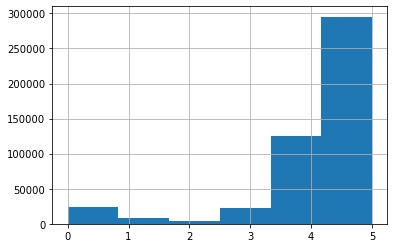

In [127]:
submission["rating"].hist(bins=6)

In [128]:
submission.to_csv("sub11.csv", index=False)